<h1><center>Creating the Network</center></h1>

In this repository we will create the PBMNet (*Pesquisa Brasileira em Matemática Network*).
This is a co-authorship network of the researchers present in our database. The ideia is
to explore the connection among the mathematics researchers and try to understand some of
the characteristics of this network.

### Overview:
1) Create SQL Database  - First, we create a SQLite database to speed-up the process
crossing authors and papers;

2) Generate the Network - Secondly, we use this database to create the edges and nodes of the network;

3) Initial Exploration  - We do some statistics of the overall network, and finally
we take a look at the graph;

4) Going Deeper         - After learning a bit about the network,
we explore the more interesting parts of the network;

### Methodology for Creating and Analysing the Network:
The network is undirected, with each node of the network representing a researcher,
and the edge between two nodes representing that the researchers published a paper together.
Each edge has a weight related to the number of papers published together. The weight of the
edges is only used in the analysis when we explicitely say so. Therefore, most of our analysis
considers that the network has no weights.

The creation of the edges in the network is done by using the field *CHAVE_ARTIGO*. In origianl data,
there is no single ID for identifying the articles, so we are left with using its name. But this can
be problematic, since the researchers can sometimes write the same name differently (e.g comma at the end
versus lack of commma in the end; upper case versus lower case). So, to avoid this problem we use the
*CHAVE_ARTIGO* field, which is the name of the article with all uppercase letters and with all spaces and
other symbols removed. Note: if you are interested in knowing how exactly we constructed this field,
take a look in the *Dataframe_from_Mongo.ipynb* notebook.

#### Note for users:
This notebook uses two network analysis libraries:
* Networkx: is the "go-to" library for python users and can easily be installed. We use it to
create the graph and to get some statistics regading the network, such as the degree distribution;
* Graph-tool: is a powerful library for analysing networks. It uses C++ with python-boost. The problem
is that it requires compiling large C++ files, and the installation process can take up to 4 hours.
We use it to mostly to visualize the network, since the *networkx* library is quite slow at that.

## 0. Importing Libraries and Dataframes

In [52]:
# The import order is important
import matplotlib as mpl 
mpl.use('cairo') 
%matplotlib inline 
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import itertools
import networkx as nx
import graph_tool.all as gt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')


In [68]:
authors =  pd.read_csv('./views/Authors.csv',encoding='latin-1',sep=';',index_col=0)
papers  =  pd.read_csv('./views/Papers.csv',encoding='latin-1',sep=';',index_col=0)

In [69]:
authors = authors.reset_index()

# As our main focus is in Mathematics, Statistics and Computer Sciences,
# we'll aggregate the counting of the other fields into Mathematics, as was reported by CNPq

def Adjust_Area(cell):
    if cell in ['Matemática','Probabilidade e Estatística','Ciência da Computação']:
        return cell
    else:
        return 'Matemática'
    
authors['AREA'] = authors['AREA'].apply(Adjust_Area)

authors.head(1)

,index,@DATA-ATUALIZACAO,@NUMERO-IDENTIFICADOR,_id,NOME-COMPLETO,AREA-ATUACAO,GRANDE-AREA,AREA,SUB-AREA,ESPECIALIDADE,NOME-INSTITUICAO,UF-INSTITUICAO,PAIS-INSTITUICAO,PAIS,NOME-CITACOES,CODIGO-INSTITUICAO
0,0,2014-10-07,2.558570e+15,5d31b6f7a4ef2aef4f143ec2,Aarão Lyra,"{'@SEQUENCIA-AREA-DE-ATUACAO': '1', '@NOME-GRA...",CIENCIAS_EXATAS_E_DA_TERRA,Ciência da Computação,Matemática da Computação,Matemática Intervalar,Universidade Potiguar,RN,Brasil,Brasil,"LYRA, A.;Lyra, A.;Lyra, Aarão;LYRA, A",000100000991


We will create a code to identify the categories. This will be used to colour the graphs using graph-tool.

In [70]:
def Code_Area(cell):
    if cell == 'Matemática': return 1
    elif cell == 'Ciência da Computação': return 0
    else: return 0.5
authors['CODE_AREA'] = authors['AREA'].apply(Code_Area)

Then, let's create a date that the author joined the network. We will consider this date equal to the date
of his first publication. For people that didn't publish, we will leave this as None.

In [77]:
papers_years = papers.sort_values(by='ANO-DO-ARTIGO',
                   ascending=True).drop_duplicates(subset='NOME-COMPLETO')[['NOME-COMPLETO',
                                                                           'ANO-DO-ARTIGO']]
papers_years.columns = ['NOME-COMPLETO','YEAR']
authors = pd.merge(authors,papers_years,on='NOME-COMPLETO',how='left')

In [78]:
authors['YEAR'] = pd.to_numeric(authors['YEAR'],errors='coerce')

In [79]:
authors.shape

(11419, 18)

In [12]:
papers.head(1)

,@NUMERO-IDENTIFICADOR,_id,NOME-COMPLETO,TITULO-DO-ARTIGO,ANO-DO-ARTIGO,JOURNAL,PALAVRAS-CHAVE-ARTIGO,COAUTORES,CHAVE_ARTIGO
0,6.115399e+15,5d31b5b9a4ef2aef4f14294d,Manuel Francisco Zuloeta Jimenez,"Weak almost periodic motions, minimality and s...",2014,Journal of Differential Equations (Print),Sistemas semidinâmicos Impulsivos|Weak almost ...,"[{'@NOME-COMPLETO-DO-AUTOR': 'BONOTTO, E.M.', ...",WEAKALMOSTPERIODICMOTIONSMINIMALITYANDSTABILIT...


## 1. Creating SQL database

The steps are pretty straight forward. Just follow the code.

In [80]:
# First, create filter the dataframe with only the columns we need
author_paper_ids = papers[['NOME-COMPLETO','CHAVE_ARTIGO']].groupby(by=['NOME-COMPLETO',
                                                                        'CHAVE_ARTIGO']).count().reset_index()

# Schema for creating the database
schema = """
DROP TABLE IF EXISTS "author_paper";
CREATE TABLE IF NOT EXISTS "author_paper" (
    paper_id VARCHAR,
    author_id VARCHAR,
    FOREIGN KEY(paper_id) REFERENCES paper(id)
    FOREIGN KEY(author_id) REFERENCES author(id)
);
"""

# Create the database using sqlite
conn = sqlite3.connect('pbmnet.sqlite',timeout=10)
cursor = conn.cursor()
cursor.executescript(schema)
conn.commit()
conn.close()

# Populate the database
ins_paper_author ="""
INSERT INTO author_paper (paper_id, author_id) \
    VALUES (?,?);
"""

conn = sqlite3.connect('pbmnet.sqlite',timeout=10)
for index,row in author_paper_ids.iterrows():
    conn.execute(ins_paper_author,[row['CHAVE_ARTIGO'],row['NOME-COMPLETO']])
conn.commit()
conn.close()

---
## 2. Generating the Network

Let's use the SQL database to generate a list of edges by comparing each author and the papers
he published with the other authors. Doing this with SQL is much faster than
using python.

In [81]:
DATABASE = 'pbmnet.sqlite'

# Create the edge list
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""
conn = sqlite3.connect(DATABASE,timeout=10)
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()

edges_authors= pd.DataFrame(edges_authors,columns=['paper','author1','author2'])

edges_authors.head(2)

,paper,author1,author2
0,APOLARREPRESENTATIONFORCOMPLEXINTERVALNUMBERS,Aarão Lyra,Benjamín René Callejas Bedregal
1,APOLARREPRESENTATIONFORCOMPLEXINTERVALNUMBERS,Aarão Lyra,Roque Mendes Prado Trindade


Let's chage the name of each author by his index in the database and count the number
of papers published together, thus, getting the weight of each edge.

In [82]:
papers_years = papers.sort_values(by='ANO-DO-ARTIGO',
                   ascending=True).drop_duplicates(subset='CHAVE_ARTIGO')[['ANO-DO-ARTIGO','CHAVE_ARTIGO']]

edges_years = pd.merge(edges_authors,papers_years,left_on='paper',
                         right_on='CHAVE_ARTIGO').drop(['CHAVE_ARTIGO'],axis=1)
edges_years = edges_years.sort_values(by='ANO-DO-ARTIGO').drop_duplicates(subset=['author1',
                                                        'author2'])[['author1','author2','ANO-DO-ARTIGO']]
edges_years['KEY_EDGE'] = edges_years['author1']+edges_years['author2']

In [84]:
count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()

count_authors = pd.merge(count_authors,authors[['index','NOME-COMPLETO']],
                             left_on='author1',right_on='NOME-COMPLETO',how='left')

count_authors = pd.merge(count_authors,authors[['index','NOME-COMPLETO']],
                             left_on='author2',right_on='NOME-COMPLETO',how='left',suffixes=('1','2'))

count_authors['KEY_EDGE'] = count_authors['author1']+count_authors['author2']

count_authors = pd.merge(count_authors,edges_years,on='KEY_EDGE',how='left')

count_authors = count_authors[['index1','index2','paper','ANO-DO-ARTIGO']]
count_authors.columns = ['author1','author2','paper','year']

count_authors.head()

,author1,author2,paper,year
0,0,1413,4,1999
1,0,9846,1,2004
2,2,7297,3,2013
3,4,296,1,2004
4,4,1096,1,2007


In [91]:
# Changing type to numeric
count_authors['year'] = pd.to_numeric(count_authors['year'])

We turn the dataframe of authors in a list of dictionaries to be inserted using the
networkx library. Hence, *authors_dict* is our list of nodes with their attributes.

In [86]:
authors_dict = authors[['index','NOME-COMPLETO','NOME-INSTITUICAO','UF-INSTITUICAO','AREA','CODE_AREA','YEAR',
                         'PAIS-INSTITUICAO','PAIS',]].to_dict(orient='records')

Finally, let's populate our graph with the list of edges and nodes we just created.

In [87]:
def Create_Network(nodes,edges,source='source', target='target',weight='weight',name='graph'):
    G = nx.Graph(name=name)
    
    for d in nodes:
        node_id = int(d['index'])
        G.add_node(node_id, **d) 
    
    for d in edges.to_dict('records'):
        G.add_edge(d[source],d[target],count = d[weight])
    return G

G = Create_Network(authors_dict,count_authors,'author1','author2','paper','pbmnet')

Network created successfuly!

----
## 3. Initial Exploration

Let's explore some basic characteristics of our network!

In [88]:
total_nodes, total_edges, avg_degree = len(G.nodes()),len(G.edges()),(2*len(G.edges())/len(G.nodes()))
print('Total Nodes = ', total_nodes)
print('Total Edges = ', total_edges)
print('Avg. Degree = ', avg_degree)
print('# Connected Components = ', nx.number_connected_components(G))

Total Nodes =  11419
Total Edges =  16164
Avg. Degree =  2.831071021980909
# Connected Components =  4531


Degree Distribution

Text(0.5, 0, 'Degree')

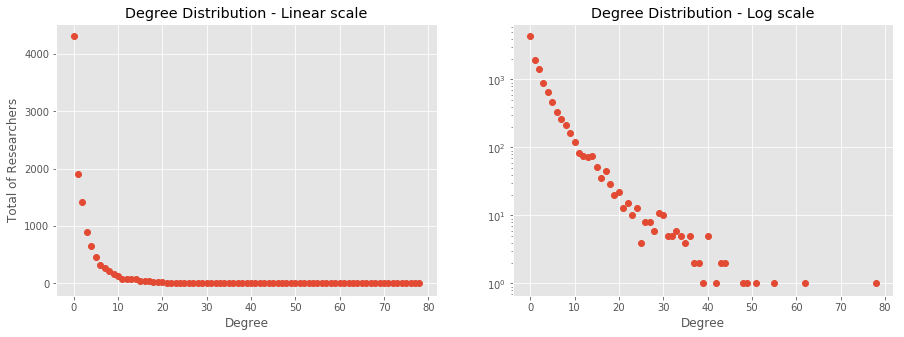

In [93]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(nx.degree_histogram(G),'o')
plt.xlabel('Degree')
plt.ylabel('Total of Researchers')
plt.title("Degree Distribution - Linear scale")
plt.subplot(122)
plt.plot(nx.degree_histogram(G),'o')
plt.yscale('log')
plt.title("Degree Distribution - Log scale")
plt.xlabel('Degree')

Let's take a look on the clustering for this network.

Avg. Clustering   =  0.20206527756060963
Median Clustering =  0.0
Avg. Clustering without zeros   =  0.5182801896820759
Median Clustering without zeros =  0.39107142857142857


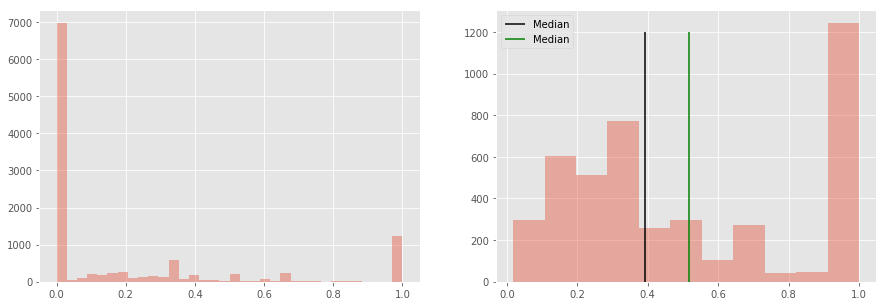

In [94]:
print('Avg. Clustering   = ', nx.average_clustering(G))
print('Median Clustering = ', np.median(list(nx.clustering(G).values())))
cluster_l0 = list(filter(lambda x: x>0,list(nx.clustering(G).values()))) # Getting values larger than 0
print('Avg. Clustering without zeros   = ', np.mean(cluster_l0))
print('Median Clustering without zeros = ', np.median(cluster_l0))

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(list(nx.clustering(G).values()),kde=False,)
plt.subplot(122)
sns.distplot(cluster_l0,kde=False,)
plt.vlines(x=np.median(cluster_l0),ymin=0,ymax=1200,label='Median')
plt.vlines(x=np.mean(cluster_l0),ymin=0,ymax=1200,label='Median',colors='g')
plt.legend()

In [95]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, bytes):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)
        print(tname,value,key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

##############################################################################################################
#### Functions adapted from https://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html ####
#### Modified by: Davi Sales Barreira                                                                     ####
#### LOG: The original code did not work on the more modern versions of networkx and python3.             ####
##############################################################################################################

In [96]:
for u,v,d in G.edges(data=True):
    d['weight'] = d['count']/40.0

In [97]:
g = gt.Graph(directed=False)
Gsub = G.subgraph(list(range(500)))
g = nx2gt(G)

string pbmnet name


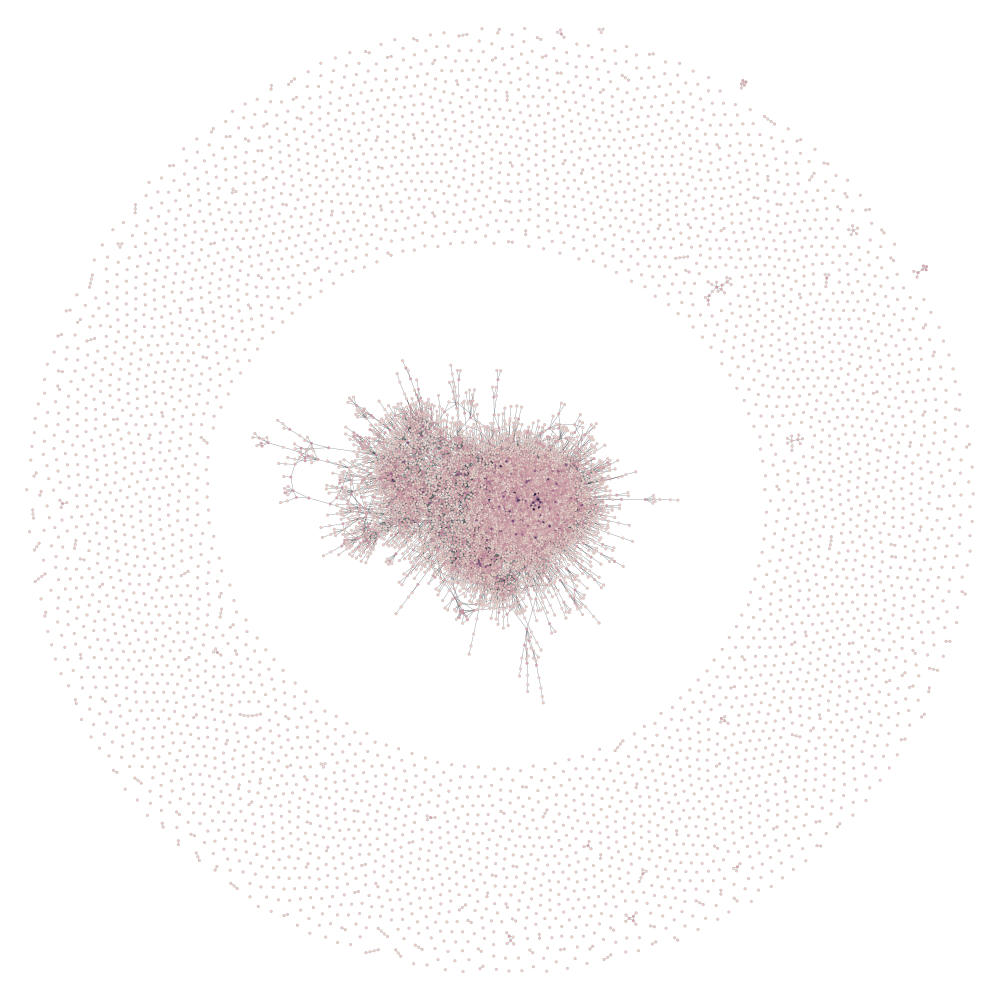

In [98]:
# The color of the node is related to the number of edges it has. The larger, the darker...
cmap = sns.cubehelix_palette(8,as_cmap=True)
deg = g.degree_property_map("total")
pos_complete = gt.graph_draw(g,vertex_fill_color=deg,vcmap=cmap,output_size=(1000,1000))

### A picture is worth a thousand words!

Now we can understanding a bit better of how our network is behaving. It seems we have one giant
component, and lots of peripherals (e.i researchers that form small connections among themselves,
or that don't even published with anyone else). We could infer something like this from the degree's
distribution, but looking at it the idea is much clearer (and prettier!).


In [99]:
gt.graph_draw(g,pos=pos_complete,vertex_fill_color=deg,vcmap=cmap,output_size=(2000,2000),output='pbmnet.png')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f68a97812e8, at 0x7f68a8542a58>

## 4. Going Deeper

After looking at the image, it's clear that we have a giant component that seems to be 
fully connected (we can get from one node to all nodes). With this, we can do some interesting
exploration.

So let's extract this largest component.

In [100]:
LG = max(nx.connected_component_subgraphs(G), key=len)
total_nodes, total_edges, avg_degree = len(LG.nodes()),len(LG.edges()),(2*len(LG.edges())/len(LG.nodes()))
print('Total Nodes = ', total_nodes)
print('Total Edges = ', total_edges)
print('Avg. Degree = ', avg_degree)
print('# Connected Components = ', nx.number_connected_components(LG))

Total Nodes =  6553
Total Edges =  15803
Avg. Degree =  4.823134442240195
# Connected Components =  1


Text(0.5, 0, 'Degree')

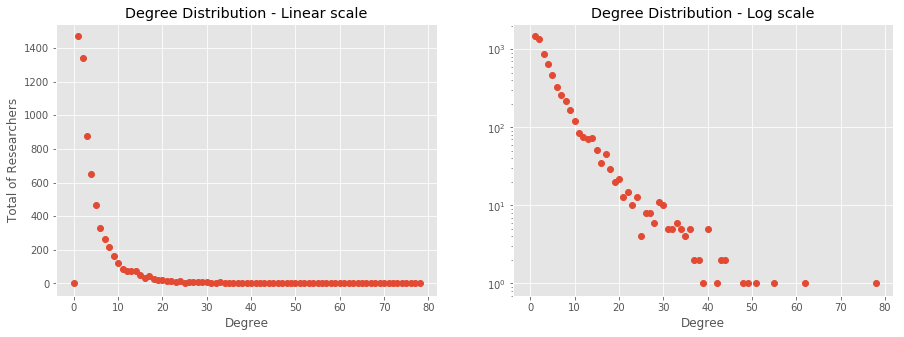

In [101]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(nx.degree_histogram(LG),'o')
plt.xlabel('Degree')
plt.ylabel('Total of Researchers')
plt.title("Degree Distribution - Linear scale")
plt.subplot(122)
plt.plot(nx.degree_histogram(LG),'o')
plt.yscale('log')
plt.title("Degree Distribution - Log scale")
plt.xlabel('Degree')

Avg. Clustering   =  0.3452744398694643
Median Clustering =  0.2222222222222222
Avg. Clustering without zeros   =  0.5150428874264972
Median Clustering without zeros =  0.38421052631578945


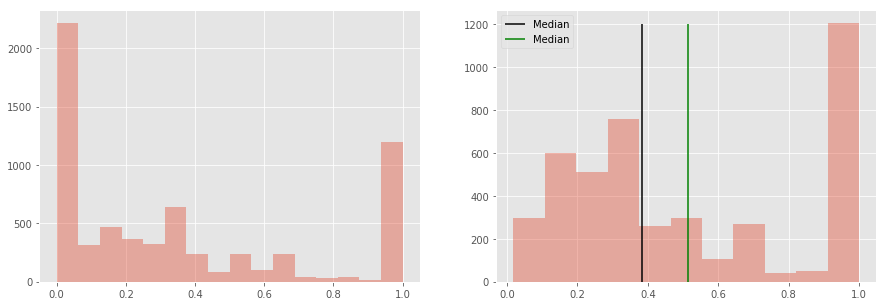

In [102]:
print('Avg. Clustering   = ', nx.average_clustering(LG))
print('Median Clustering = ', np.median(list(nx.clustering(LG).values())))
cluster_l0 = list(filter(lambda x: x>0,list(nx.clustering(LG).values()))) # LG values larger than 0
print('Avg. Clustering without zeros   = ', np.mean(cluster_l0))
print('Median Clustering without zeros = ', np.median(cluster_l0))

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(list(nx.clustering(LG).values()),kde=False,)
plt.subplot(122)
sns.distplot(cluster_l0,kde=False,)
plt.vlines(x=np.median(cluster_l0),ymin=0,ymax=1200,label='Median')
plt.vlines(x=np.mean(cluster_l0),ymin=0,ymax=1200,label='Median',colors='g')
plt.legend()

Let's check who are the researchers that have the largest degree, hence, published papers
with several other people in the network.

In [103]:
highest_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

In [104]:
df_degree = pd.DataFrame(highest_degree,columns=['index','Degree'])
authors_degree = pd.merge(authors,df_degree,on='index')
authors_degree[['NOME-COMPLETO','UF-INSTITUICAO','Degree']].sort_values(by=['Degree'],
                                                               ascending=False).iloc[0:15]

,NOME-COMPLETO,UF-INSTITUICAO,Degree
4091,Gauss Moutinho Cordeiro,PE,78
1752,Carlos José Pereira de Lucena,RJ,62
912,André Carlos Ponce de Leon Ferreira de Carvalho,SP,55
7272,Marcos André Gonçalves,MG,51
11150,Wagner Meira Junior,MG,49
1088,Antonio Alfredo Ferreira Loureiro,MG,48
3812,Flávia Coimbra Delicato,RJ,44
8707,Paulo Henrique Monteiro Borba,PE,44
5887,Julio Cesar Sampaio do Prado Leite,RJ,43
8297,Nelson Maculan Filho,RJ,43


Guess what?! **Gauss** is the **most "connected"** brazilian mathematician! 

In [105]:
lg = gt.extract_largest_component(g)

### What are the degrees of separation?
An interesting question is, how far away is each math reasercher from each other?
This is known as the degrees of separation. An usual adage is that the world has
[6 degrees of separation](https://en.wikipedia.org/wiki/Six_degrees_of_separation),
thus, we are all related to each other by 6 people apart.

How does this hold for our giant connected component? Let's see!

In [106]:
dist = gt.shortest_distance(lg)
ave_path_length = sum([sum(i) for i in dist])/(lg.num_vertices()**2-lg.num_vertices())

In [107]:
np.round(ave_path_length,2)

6.94

The researchers are on average **7** degrees apart!

### What about the Elon Number?
The [Erdos number](https://oakland.edu/enp/) describes the "collaborative distance" between mathematician Paul Erdos and
another researcher, measured using the co-authorship as in our network.

So why not create the brazilian version? In Brazil, **Elon Lages Lima** is a proeminent mathematician,
but he is completetly diffrent from Erdos in the sense that Erdos is known for having published
an absurd amount of papers and having collaborated with an extraordinary amount of people. This is
the precise opposite of Elon, which has a co-authorship with only one person (Manfredo Perdigão).
Therefore, perhaps Elon is not the "right" person to build our metric around. But we (the ones
creating this notebook) quite enjoyed his book on Real Analysis, so we'll follow with him (also Elon/Erdos
makes it all the more amusing).

Below, we extract the shortest distance from Elon to each researcher in the network. Note that he is
in the giant component, so all the researchers that are not in the component will be assigned a 
distance of 0.

In [108]:
elon_index = authors_degree['index'][authors_degree['NOME-COMPLETO']=='Elon Lages Lima'].values[0]

In [109]:
v = g.vertex(elon_index)
elon_number = gt.shortest_distance(lg,source=v)
elon_number = list(elon_number.a)

Let's check if the code worked by finding out who is the person that has an Elon number of 1, which should be
Manfredo.

In [110]:
authors_degree[authors_degree['index'] == elon_number.index(1)]

,index,@DATA-ATUALIZACAO,@NUMERO-IDENTIFICADOR,_id,NOME-COMPLETO,AREA-ATUACAO,GRANDE-AREA,AREA,SUB-AREA,ESPECIALIDADE,NOME-INSTITUICAO,UF-INSTITUICAO,PAIS-INSTITUICAO,PAIS,NOME-CITACOES,CODIGO-INSTITUICAO,CODE_AREA,YEAR,Degree
6919,6919,2019-06-01,4.606011e+15,5d31b790a4ef2aef4f14480e,Manfredo Perdigao do Carmo,"{'@SEQUENCIA-AREA-DE-ATUACAO': '1', '@NOME-GRA...",CIENCIAS_EXATAS_E_DA_TERRA,Matemática,Geometria e Topologia,Geometria Diferencial,Instituto Nacional de Matemática Pura e Aplicada,RJ,Brasil,Brasil,"DoCARMO, M. P.;do Carmo, Manfredo P.;do Carmo,...",005800000006,1.0,1965.0,15


It's working! So we will assign everyone his respective number.

In [111]:
authors_degree.sort_values(by='index',inplace=True)
authors_degree['Elon_Number'] = pd.Series(elon_number)

Distribuition of Elon Numbers 

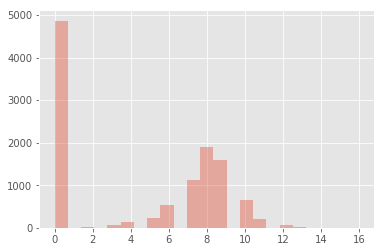

In [112]:
sns.distplot(np.array(elon_number),kde=False,)

#####  Visualizing the Giant Connected Component

The color of the node represent it's degree. The darker the higher the degree. Also, the size of
the node grows with it's centrality, measured using *pagerank*.

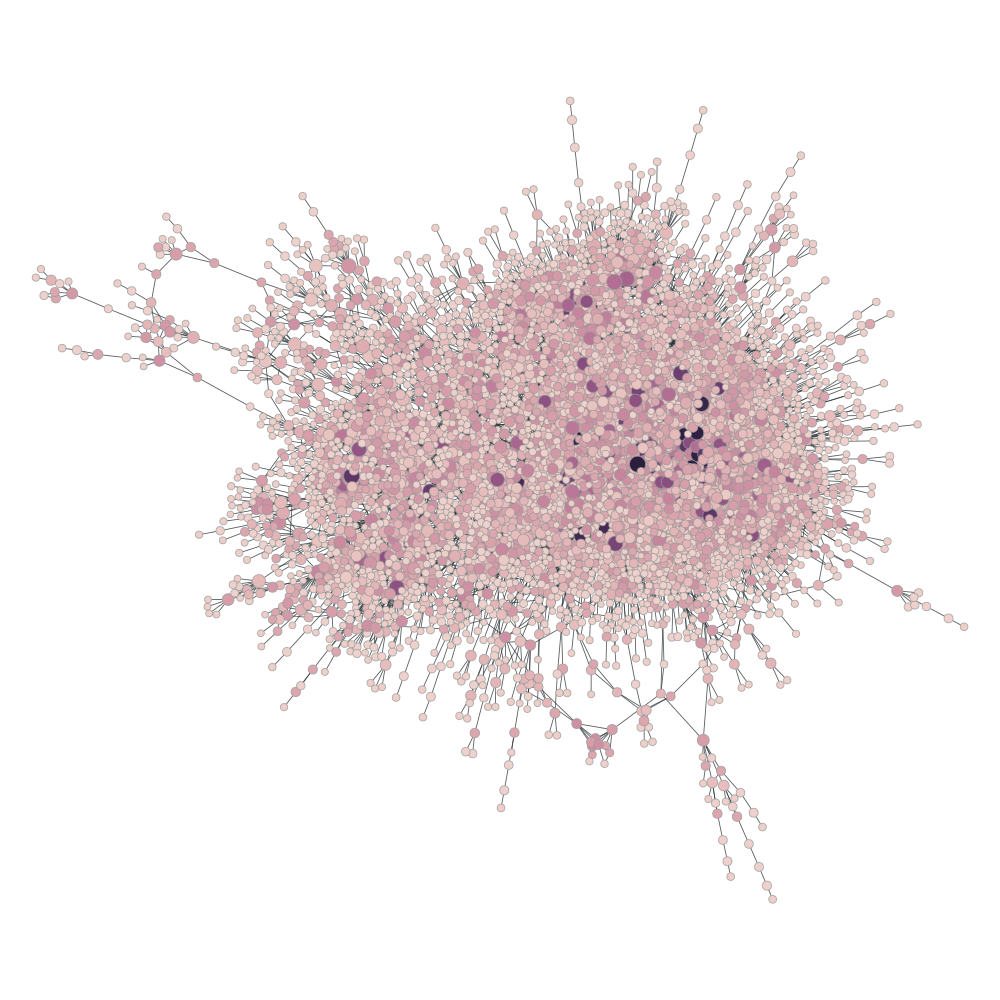

In [113]:
deg = lg.degree_property_map("total")
pr  = gt.pagerank(lg)
pos = gt.graph_draw(lg,vertex_fill_color=deg,vertex_size=gt.prop_to_size(pr, mi=5, ma=20),
              vcmap=cmap,output_size=(1000,1000))

#### Visualizing the Minimum Spanning Tree

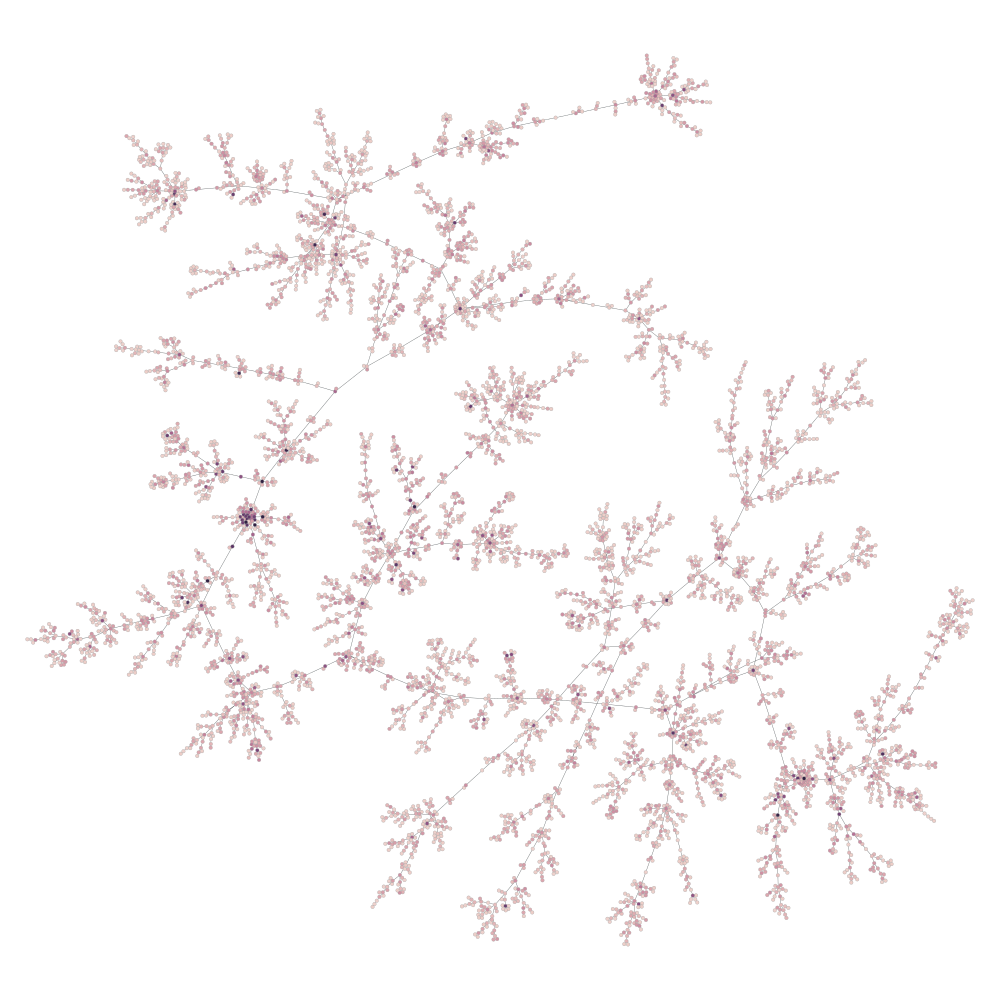

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f68a3b2b550, at 0x7f68a94d8f60>

In [114]:
tree   = gt.min_spanning_tree(lg)
u = gt.GraphView(lg, efilt=tree)
gt.graph_draw(u,vcmap=cmap,vertex_fill_color=deg,output_size=(1000,1000))

In [115]:
authors_degree['Giant_Component'] = authors_degree['Elon_Number']>0

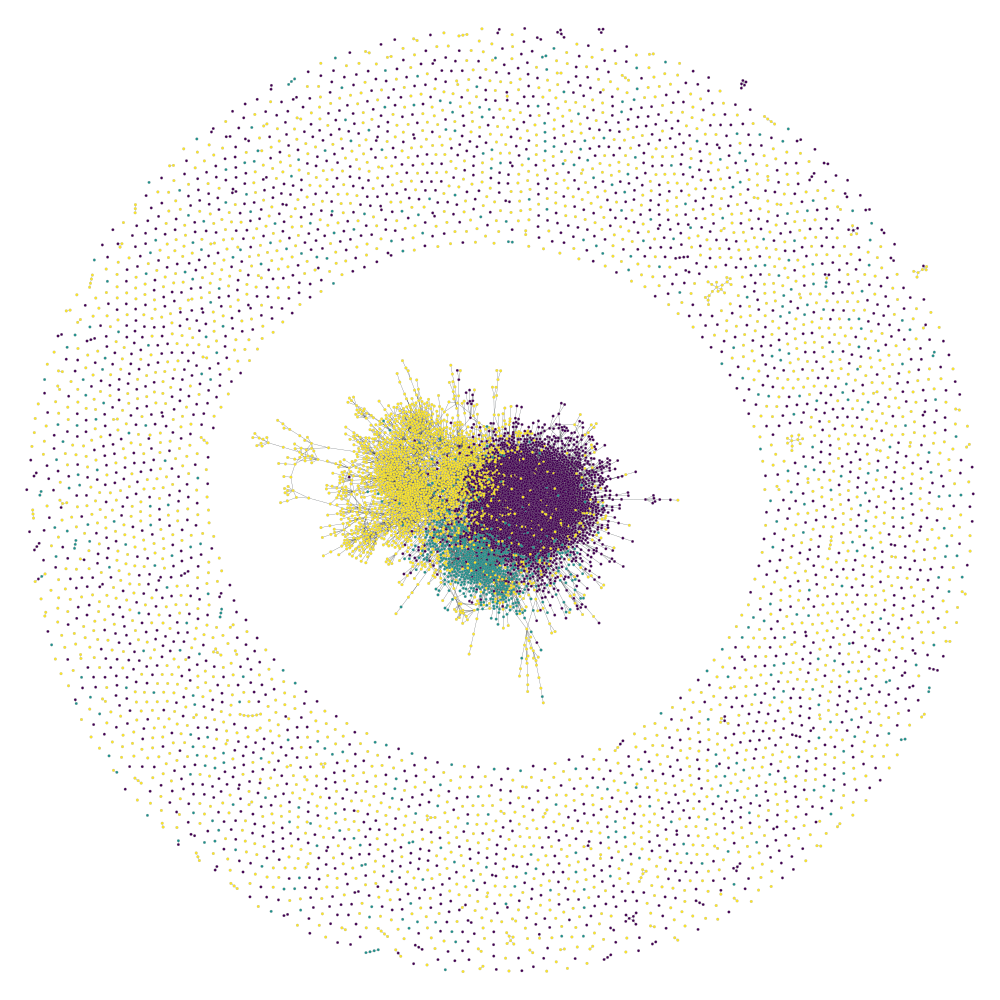

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f68a97812e8, at 0x7f68a8542a58>

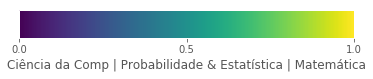

In [141]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)

bounds = [0,0.5,1]
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,ticks=bounds,
                                orientation='horizontal')
cb1.set_label('Ciência da Comp | Probabilidade & Estatística | Matemática')
fig.show()

cmap = sns.cubehelix_palette(8,as_cmap=True)
cmap = mpl.cm.viridis
deg = g.degree_property_map("total")
gt.graph_draw(g,pos=pos_complete,vertex_fill_color=g.vp['CODE_AREA'],vcmap=cmap,output_size=(1000,1000))